CODE BLOCK: 1

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [28]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [29]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [30]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)

CODE BLOCK: 5

In [31]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

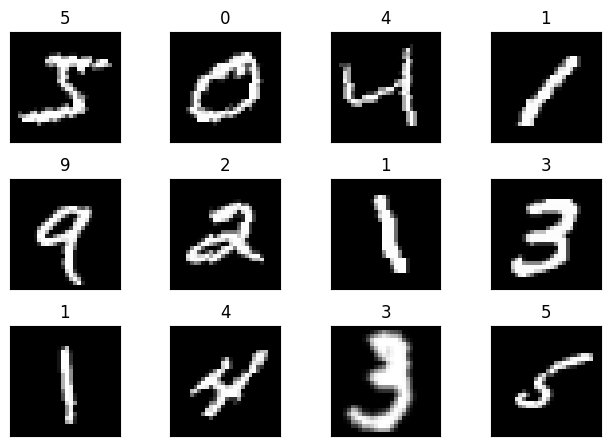

In [32]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [33]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        # print(x.shape)
        x = x.view(x.size(0),-1)
        # print()
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [34]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [35]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

In [36]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### CODE BLOCK: 9

In [38]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [37]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, train_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 1


Train: Loss=nan Batch_id=117 Accuracy=9.91: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 2


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 3


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 4


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 5


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 6


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 7


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 8


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 9


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: nan, Accuracy: 5923/60000 (9.87%)

Adjusting learning rate of group 0 to 1.0010e+01.
Epoch 10


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Test Accuracy')

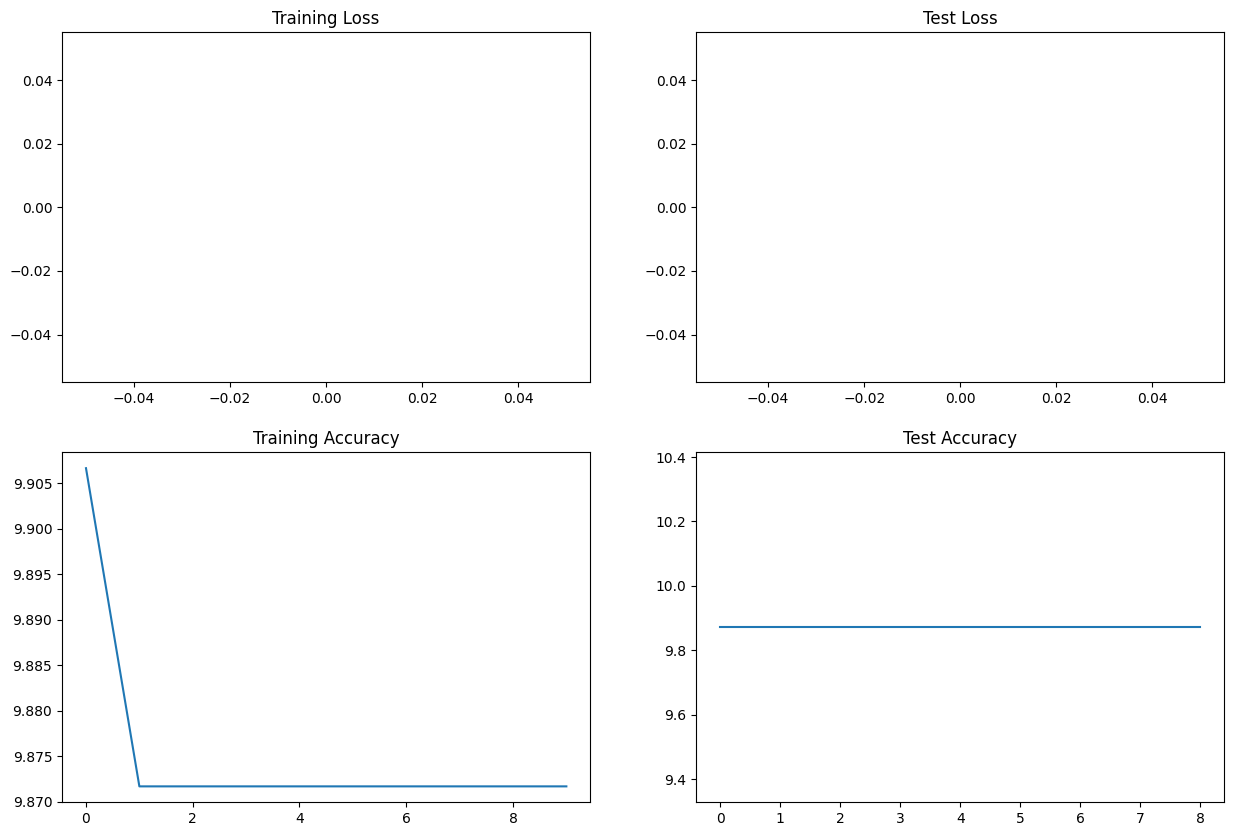

In [39]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### CODE BLOCK: 10 - Revised Network

In [40]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [41]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, train_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.4994 Batch_id=117 Accuracy=32.58: 100%|██████████| 118/118 [00:28<00:00,  4.12it/s]


Test set: Average loss: 1.4582, Accuracy: 39276/60000 (65.46%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.3077 Batch_id=117 Accuracy=87.08: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.1934, Accuracy: 56319/60000 (93.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2563 Batch_id=117 Accuracy=95.25: 100%|██████████| 118/118 [00:23<00:00,  4.97it/s]


Test set: Average loss: 0.1201, Accuracy: 57799/60000 (96.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2287 Batch_id=117 Accuracy=96.57: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


Test set: Average loss: 0.1061, Accuracy: 57930/60000 (96.55%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.2149 Batch_id=117 Accuracy=97.09: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.0902, Accuracy: 58290/60000 (97.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1795 Batch_id=117 Accuracy=97.53: 100%|██████████| 118/118 [00:22<00:00,  5.14it/s]


Test set: Average loss: 0.0814, Accuracy: 58462/60000 (97.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1775 Batch_id=117 Accuracy=97.70: 100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


Test set: Average loss: 0.0667, Accuracy: 58755/60000 (97.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1771 Batch_id=117 Accuracy=97.96: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0616, Accuracy: 58808/60000 (98.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1657 Batch_id=117 Accuracy=98.16: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0558, Accuracy: 58956/60000 (98.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1651 Batch_id=117 Accuracy=98.26: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0510, Accuracy: 59038/60000 (98.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1347 Batch_id=117 Accuracy=98.34: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Test set: Average loss: 0.0475, Accuracy: 59109/60000 (98.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1126 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0421, Accuracy: 59192/60000 (98.65%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1210 Batch_id=117 Accuracy=98.48: 100%|██████████| 118/118 [00:23<00:00,  5.05it/s]


Test set: Average loss: 0.0455, Accuracy: 59125/60000 (98.54%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1292 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:22<00:00,  5.30it/s]


Test set: Average loss: 0.0436, Accuracy: 59166/60000 (98.61%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0934 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0365, Accuracy: 59289/60000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0915 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


Test set: Average loss: 0.0302, Accuracy: 59439/60000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.1036 Batch_id=117 Accuracy=99.05: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0297, Accuracy: 59453/60000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0714 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0290, Accuracy: 59446/60000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.1465 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


Test set: Average loss: 0.0299, Accuracy: 59449/60000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.1082 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0299, Accuracy: 59449/60000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

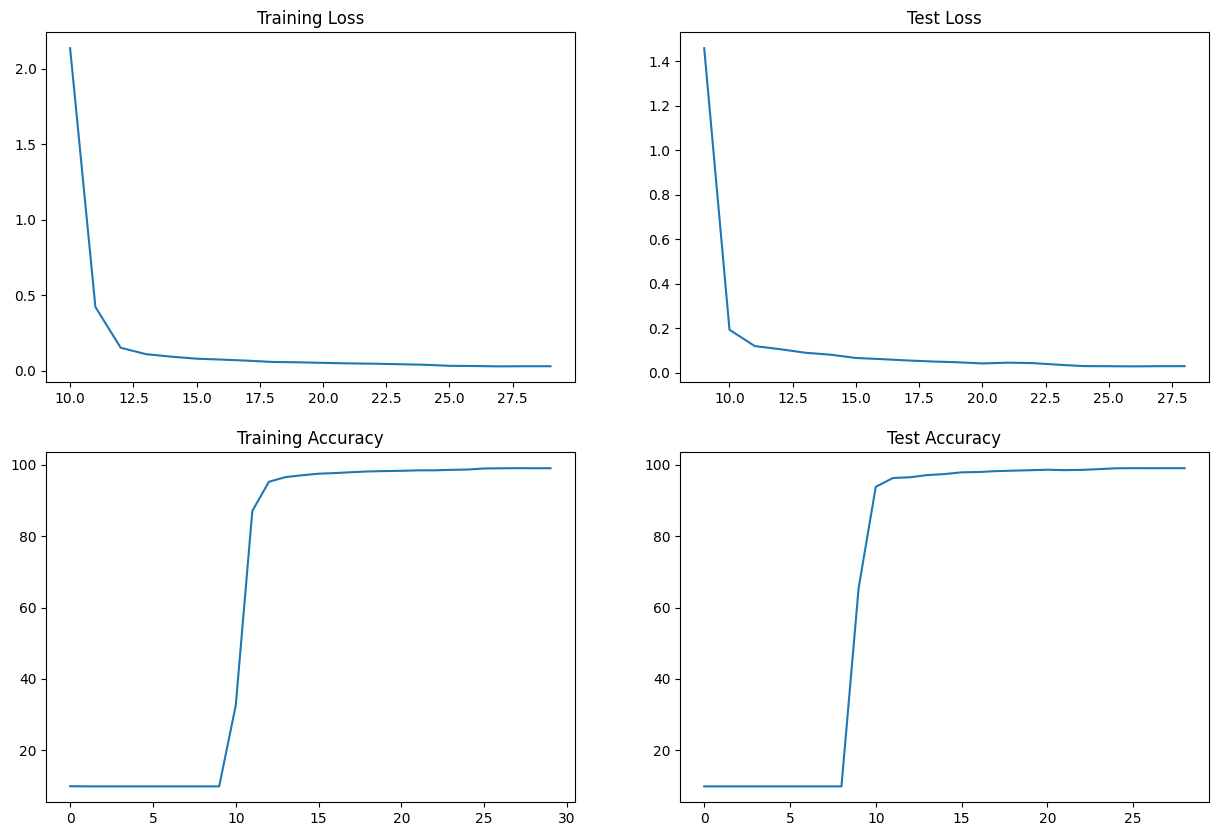

In [42]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### CODE BLOCK: 11 - Further Revised Network

In [43]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) 
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        # self.fc1 = nn.Linear(256 * 4 * 4, 50)
        self.fc2 = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) ## 28x28
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) ## 26x26 ==> 13x13
        x = F.relu(self.conv3(x), 2) ## 11x11
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) ## 9x9 ==> 4x4
        # print(x.shape)
        x = x.view(x.size(0),-1)
        # print()
        # x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [44]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 10]          40,970
Total params: 428,810
Trainable params: 428,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.64
Estimated Total Size (MB): 2.31
----------------------------------------------------------------


In [45]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, train_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3875 Batch_id=117 Accuracy=67.76: 100%|██████████| 118/118 [00:31<00:00,  3.80it/s]


Test set: Average loss: 0.2045, Accuracy: 56213/60000 (93.69%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2172 Batch_id=117 Accuracy=95.20: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.1191, Accuracy: 57794/60000 (96.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2259 Batch_id=117 Accuracy=96.81: 100%|██████████| 118/118 [00:22<00:00,  5.30it/s]


Test set: Average loss: 0.0895, Accuracy: 58310/60000 (97.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1873 Batch_id=117 Accuracy=97.34: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0810, Accuracy: 58540/60000 (97.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.2105 Batch_id=117 Accuracy=97.60: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0700, Accuracy: 58711/60000 (97.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1930 Batch_id=117 Accuracy=97.88: 100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


Test set: Average loss: 0.0610, Accuracy: 58878/60000 (98.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1613 Batch_id=117 Accuracy=98.09: 100%|██████████| 118/118 [00:22<00:00,  5.15it/s]


Test set: Average loss: 0.0579, Accuracy: 58905/60000 (98.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1946 Batch_id=117 Accuracy=98.23: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Test set: Average loss: 0.0545, Accuracy: 58994/60000 (98.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1926 Batch_id=117 Accuracy=98.40: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.0531, Accuracy: 58991/60000 (98.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1655 Batch_id=117 Accuracy=98.45: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


Test set: Average loss: 0.0512, Accuracy: 58995/60000 (98.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1560 Batch_id=117 Accuracy=98.53: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0485, Accuracy: 59058/60000 (98.43%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1155 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0438, Accuracy: 59190/60000 (98.65%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1675 Batch_id=117 Accuracy=98.68: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s]


Test set: Average loss: 0.0429, Accuracy: 59168/60000 (98.61%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1269 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0422, Accuracy: 59189/60000 (98.65%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.1362 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:28<00:00,  4.15it/s]


Test set: Average loss: 0.0392, Accuracy: 59234/60000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0850 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Test set: Average loss: 0.0310, Accuracy: 59447/60000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0936 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0299, Accuracy: 59437/60000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.1064 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:23<00:00,  5.11it/s]


Test set: Average loss: 0.0296, Accuracy: 59420/60000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0770 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s]


Test set: Average loss: 0.0295, Accuracy: 59463/60000 (99.11%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0862 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0280, Accuracy: 59476/60000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

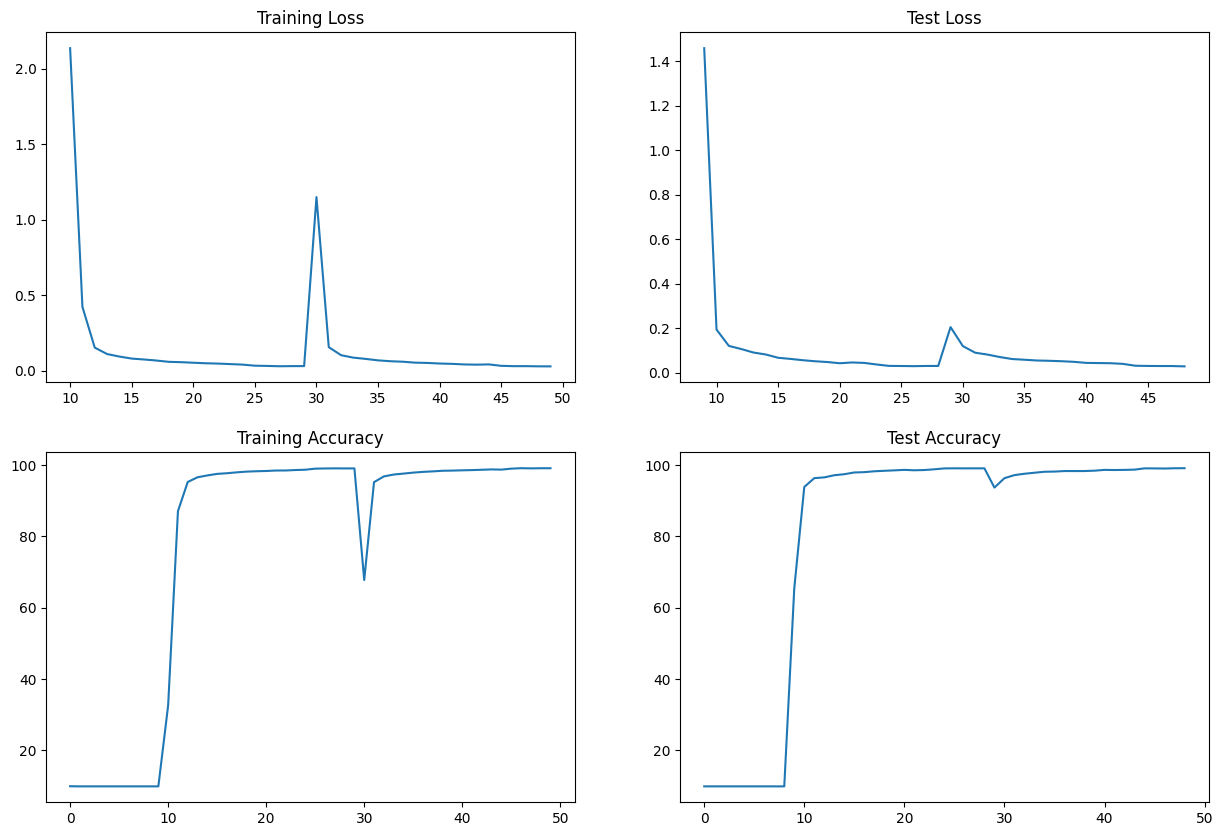

In [46]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")